Set up generative modeling as a reinforcement learning problem

Model: Just a decoder

Env step: Predict & backprop latents, updating latents repeatedly at each step. 

Reward: - Total reconstruction error over X steps.

Outcome: Model that can quickly 'learn' an image while viewing it, and learn a good latent space. 

In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tf
import numpy as np

def show(data, rows):
    imgs = vutils.make_grid(data, nrow=rows, normalize=True)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tf.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [2]:
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.nn import functional as F
from torch import nn
import torch
import torchvision.utils as vutils
from torch import optim

batch_size = 1024

mnist_32_norm = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Pad(2),  # Get to 32 x 32
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

dl = DataLoader(MNIST(".", train=True, transform=mnist_32_norm), batch_size=batch_size, num_workers=8) 

In [3]:
block = lambda in_dim, out_dim: nn.Sequential(
    nn.ConvTranspose2d(
        in_dim,
        out_dim,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=1
    ),
    nn.BatchNorm2d(out_dim),
    nn.LeakyReLU()
)

        

In [4]:
modules = []
latents = []
hidden_dims = [256, 128, 64, 32, 16, 8]
latent_dim = hidden_dims[0]

grid_size = 1
latents = torch.randn(batch_size, latent_dim, grid_size, grid_size, requires_grad=True)

for i in range(len(hidden_dims) - 1):
    modules.append(block(hidden_dims[i], hidden_dims[i + 1]))
    
    #latents.append(
    #    torch.randn(batch_size, hidden_dims[i], grid_size, grid_size, requires_grad=True)
    #)
    grid_size = grid_size * 2

final = nn.Sequential(
    nn.Conv2d(hidden_dims[-1], out_channels=1,
              kernel_size=3, padding=1),
    nn.Tanh()
) 

decoder = nn.Sequential(*modules)

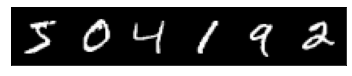

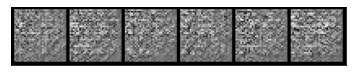

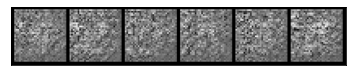

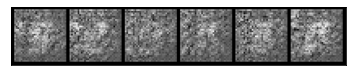

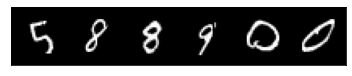

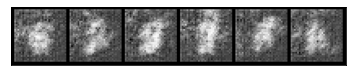

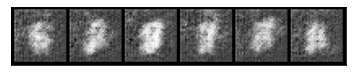

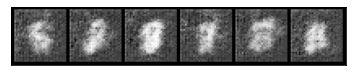

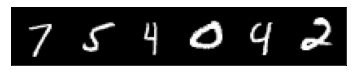

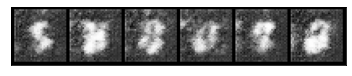

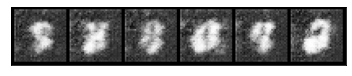

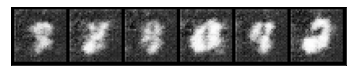

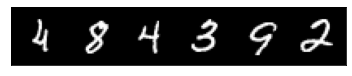

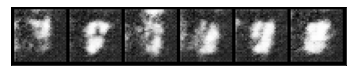

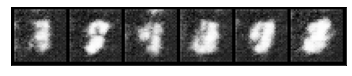

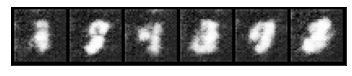

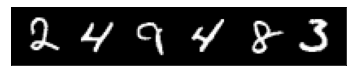

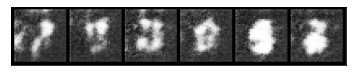

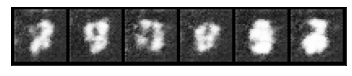

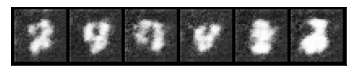

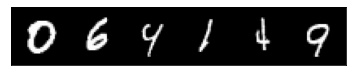

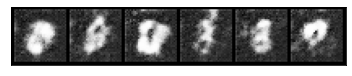

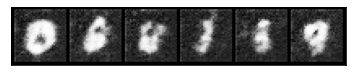

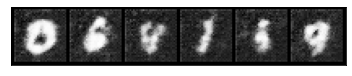

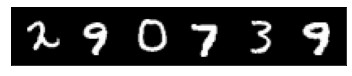

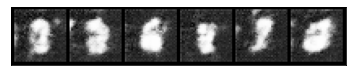

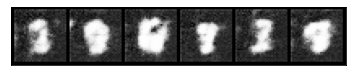

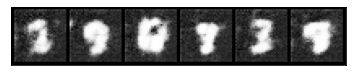

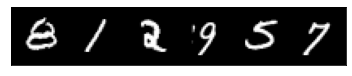

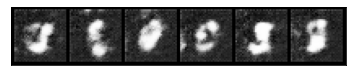

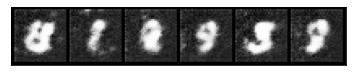

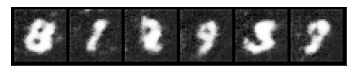

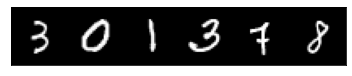

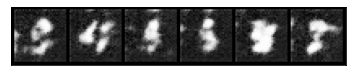

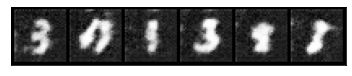

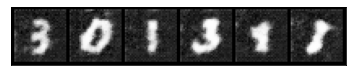

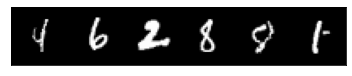

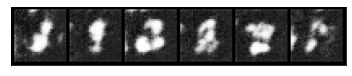

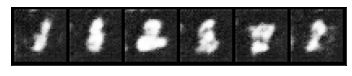

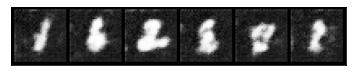

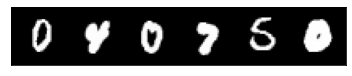

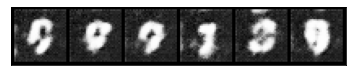

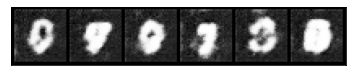

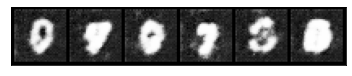

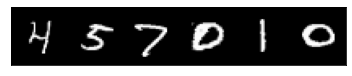

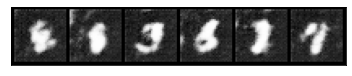

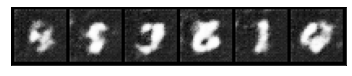

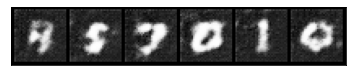

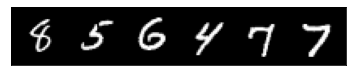

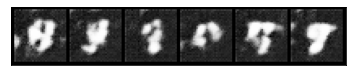

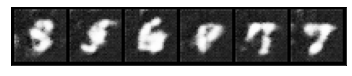

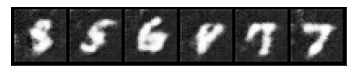

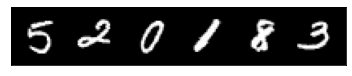

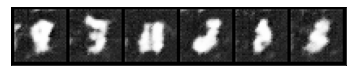

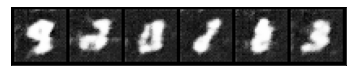

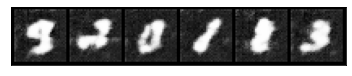

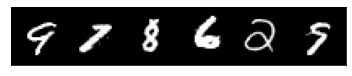

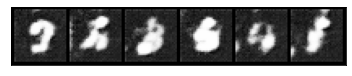

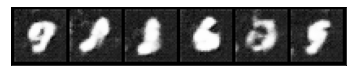

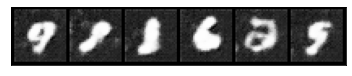

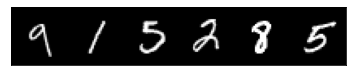

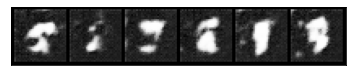

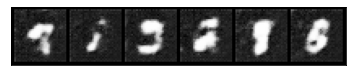

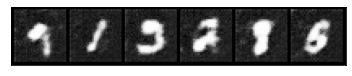

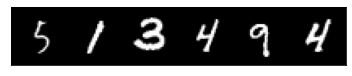

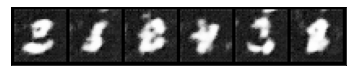

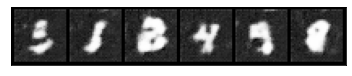

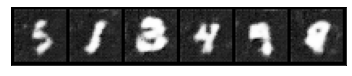

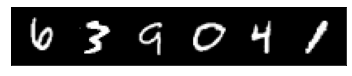

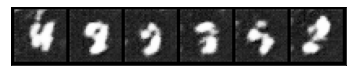

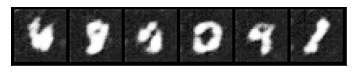

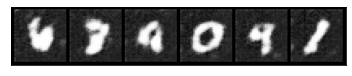

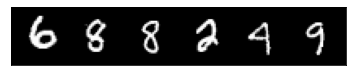

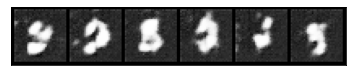

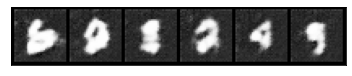

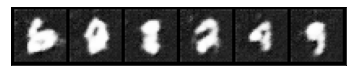

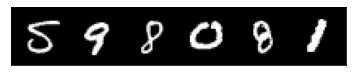

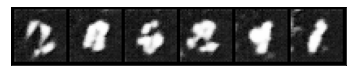

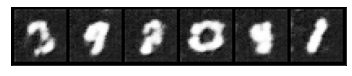

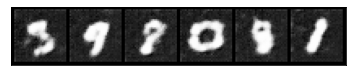

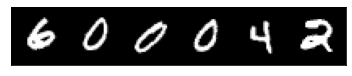

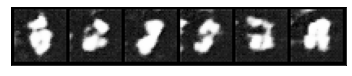

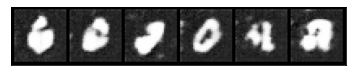

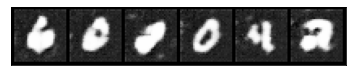

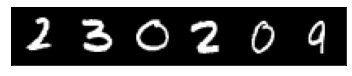

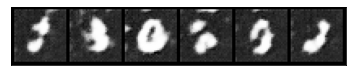

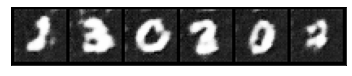

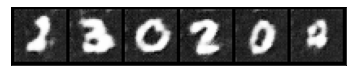

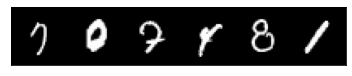

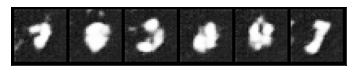

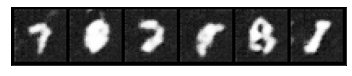

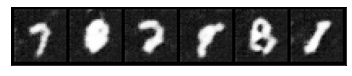

In [ ]:
inspections = 3200

latent_optim = optim.SGD([latents], lr=1e-2, momentum=0.9)
backbone_optim = optim.SGD(decoder.parameters(), lr=1e-4, momentum=0.9)

for sample, label in iter(dl):
    show(sample[0:6], rows=6)
    #for latent in latents:
    nn.init.xavier_uniform_(latents)
        
    for i in range(inspections):

        backbone_optim.zero_grad()
        latent_optim.zero_grad()

        """
        losses = []
        prev_starts = []
        prev_layer = None
        for layer, latent in zip(decoder, latents):
            latent = torch.tanh(latent)
            prev_layer = layer
            prev_starts = [layer(p) for p in prev_starts]
            prev_starts.append(layer(latent))
            
        recons = [final(p) for p in prev_starts]
        losses = [F.mse_loss(r, sample) for r in recons]
        loss = sum(losses)
        """
        recons = final(decoder(latents))
        loss = F.mse_loss(recons, sample)
        loss.backward()

        latent_optim.step()
        backbone_optim.step()
        if i in [100, 600, 1199]:

            #recons = [final(p) for p in prev_starts]
            #recons = torch.cat(recons, dim=0)
            
            #final(decoder(latents[0]))
            show(recons[0:6], rows=6)
            
        

In [ ]:
class Memory(nn.Module):
    def __init__(key_dim, latent_dim, size):
        self.memory = torch.randn(size, latent_dim, 1, 1, requires_grad=True)
        self.keys = torch.randn(size, key_dim, requires_grad=True)
        
    def forward(self, query):